In [1]:
import random
import re
import sys
import yaml
# Display
from IPython.display import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import zipfile
import os
import wget
import zipfile
import numpy as np
import pandas as pd

In [3]:
!python -m zipfile -c vgg.zip model

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory as im_from_dir
from tensorflow.keras import Model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras

In [3]:
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import glob

In [2]:
#!pip install tensorflow-gpu

  Using cached grpcio-1.32.0-cp37-cp37m-manylinux2014_x86_64.whl (3.8 MB)
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx 0.26.0 requires kubernetes<12,>=10.0.1, but you have kubernetes 12.0.1 which is incompatible.
tfx 0.26.0 requires pyarrow<0.18,>=0.17, but you have pyarrow 2.0.0 which is incompatible.
tensorflow 2.3.2 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.3.2 requires tensorflow-estimator<2.4.0,>=2.3.0, but you have tensorflow-estimator 2.4.0 which is incompatible.
tensorflow-transform 0.26.0 requires pyarrow<0.18,>=0.17, but you have pyarrow 2.0.0 which is incompatible.
tensorflow-model-analysis 0.26.0 requires pyarrow<0.18,>=0.17, but you have 

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
#TensorFlow:2.3
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Thu_Jun_11_22:26:38_PDT_2020
Cuda compilation tools, release 11.0, V11.0.194
Build cuda_11.0_bu.TC445_37.28540450_0


In [10]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
!nvidia-smi

Sun Feb 14 08:26:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    63W / 149W |      0MiB / 11441MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
tf.test.is_built_with_cuda()

True

In [11]:
print(tf.__version__)

2.4.1


## Importing data

In [ ]:
#!wget --quiet --no-check-certificate 'https://storage.googleapis.com/vaibhav_instance1/Train_small.zip' -O train.zip

In [37]:
!wget --quiet --no-check-certificate 'https://storage.googleapis.com/ecologists_projecta_bucket/TEST_RAW_IMAGES_12500.zip' -O test.zip

In [93]:
zf = zipfile.ZipFile('test.zip', 'r')

In [94]:
with zf as zip_ref:
     zip_ref.extractall(r"TL/data/test/")

In [148]:
!autosave=1

In [3]:
!rm -r data/.ipynb_checkpoints
!rm -r data/bee/.ipynb_checkpoints
!rm -r data/butterfly/.ipynb_checkpoints
!rm -r data/insect/.ipynb_checkpoints
!rm -r data/other/.ipynb_checkpoints
!rm -r data/wasp/.ipynb_checkpoints

rm: cannot remove 'data/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'data/bee/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'data/butterfly/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'data/insect/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'data/other/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'data/wasp/.ipynb_checkpoints': No such file or directory


# Using CNN

We use CNN which is the goto model for image classification tasks.
16-32-64 convolutional layers with max-pooling in between is
pretty standard for and we use it as a first attempt, with a fully connected layer
at the end and an output layer of 5 nodes for the 5 classes.

We use 'sparse_categorical_crossentropy' for loss and the sgd algorithm
'adam' for the optimizer.

In [8]:
directory = 'data/'

In [12]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to images
"""train_datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split = 0.2,
    rescale=1./255)"""

train_datagen = ImageDataGenerator(
    rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_data = train_datagen.flow_from_directory(
    'TL/data/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse') # set as training data

val_data = val_datagen.flow_from_directory(
    'TL/data/val', # same directory as training data
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse') # set as validation data

Found 241557 images belonging to 5 classes.
Found 3000 images belonging to 5 classes.


In [57]:
# Our input feature map is 128x128x3: 128x128 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(128, 128, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3 
# followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Output layer with a 13 nodes and sigmoid activation
output = layers.Dense(5, activation='softmax')(x)

In [58]:
# Create model
model = Model(img_input, output)
model.summary()

# Using sparse categorical cross-entropy as loss function since we have multi-class classification
# and sparse to avoid encoding
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0   

In [59]:
hist = model.fit_generator(
    train_data,
    steps_per_epoch = train_data.samples // 32,
    validation_data = val_data, 
    validation_steps = val_data.samples // 32,
    epochs = 10)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
250/250 [==============================] - 58s 228ms/step - loss: 1.6604 - acc: 0.2924 - val_loss: 1.3038 - val_acc: 0.4637
Epoch 2/10
250/250 [==============================] - 10s 39ms/step - loss: 1.2144 - acc: 0.5042 - val_loss: 1.1529 - val_acc: 0.5363
Epoch 3/10
250/250 [==============================] - 10s 39ms/step - loss: 1.0965 - acc: 0.5597 - val_loss: 1.0873 - val_acc: 0.5756
Epoch 4/10
250/250 [==============================] - 10s 40ms/step - loss: 1.0037 - acc: 0.5952 - val_loss: 1.0415 - val_acc: 0.5801
Epoch 5/10
250/250 [==============================] - 10s 40ms/step - loss: 0.9311 - acc: 0.6273 - val_loss: 0.9992 - val_acc: 0.6089
Epoch 6/10
250/250 [==============================] - 10s 39ms/step - loss: 0.8795 - acc: 0.6543 - val_loss: 0.9927 - val_acc: 0.6064
Epoch 7/10
250/250 [==============================] - 10s 39ms/step - loss: 0.8289 - acc: 0.6658 - val_loss: 0.9366 - val_acc: 0.6295
Epoch 8/10
250/250 [==============================] - 10s 40m

In [64]:
model.predict(x)

array([[0.7558851 , 0.1013724 , 0.13215224, 0.00817707, 0.00241322]],
      dtype=float32)

Note that the following learning curves were plotted using a train-val split in the train dataset because
the validation data for the full-dataset 'public-data' was found to be null, and hence are not 
representative of the actual final model performance (which has more training data).

Text(0.5, 1.0, 'Training and validation loss')

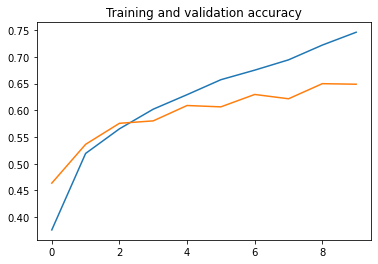

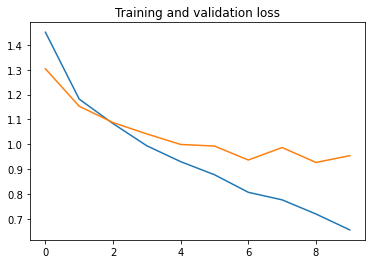

In [60]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = hist.history['acc']
val_acc = hist.history['val_acc']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

## Load a random sample

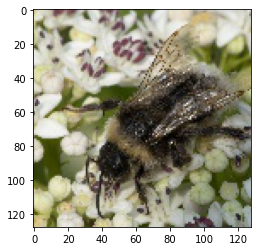

In [28]:
# Let's prepare a random input image of a cat or dog from the training set.
bee_img_files = glob.glob("data/bee/*.jpg")

img_path = random.choice(bee_img_files)

#img_path = 'data/bee/01ab2dad-e95b-4a51-a45e-9a37a99de1ad.jpg'
img = load_img(img_path, target_size=(128, 128))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

plt.imshow(img)

## Plotting layer-wise features

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


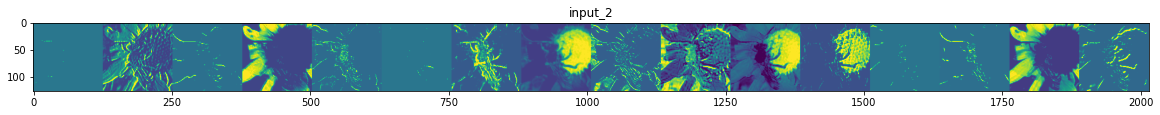

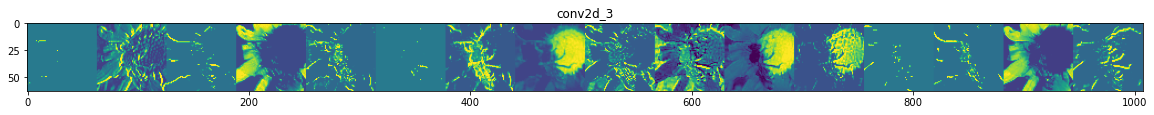

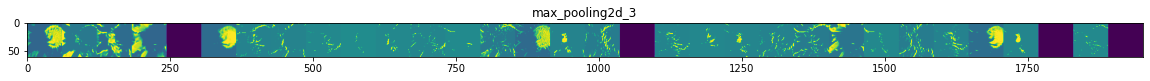

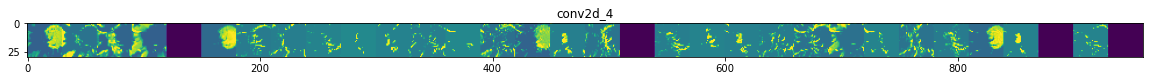

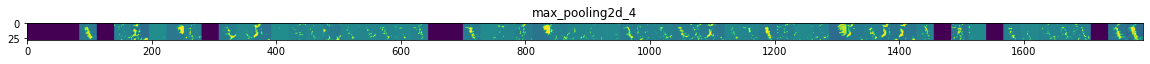

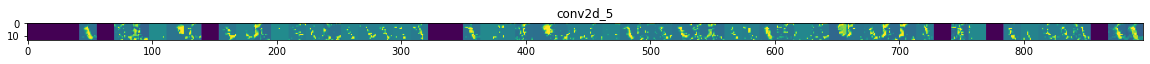

In [20]:

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Transfer Learning for insect classification
We use VGG-16 for transfer learning. We first train the top layer freezing rest of the layers to initialize the weights of the top layer.
Then training the top layer alongwith 1 or 2 Convolution blocks.
We try this with VGG-16 where we first train only the last layer, but after that also train the last conv block in fine tuning the model.

Note that we switch to 'RMS' for training top layer and 'SGD' for fine tuning
instead of 'adam' which is known to not converge for vgg-16. We discovered this rather painfully.

#  VGG-16

In [14]:
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
# load model
base_model = VGG16(include_top=False, input_shape=(128, 128, 3), weights=None)

local_weights_file = 'weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model.load_weights(local_weights_file)

In [15]:
# mark loaded layers as not trainable
for layer in base_model.layers:
    layer.trainable = False

for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [16]:
# create new model on top
top_model = layers.Flatten()(base_model.layers[-1].output)
top_model =  layers.Dense(512, activation='relu')(top_model)

# Add a dropout rate of 0.5. Essential since these models would easily overfit out limited data
top_model = layers.Dropout(0.5)(top_model)
output = layers.Dense(5, activation='softmax')(top_model)

# define new model
model = Model(base_model.inputs, output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [12]:
# train the top layer
model.compile(optimizer=RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [5]:
!rm -r TL/data/train/.ipynb_checkpoints
!rm -r TL/data/val/.ipynb_checkpoints
!rm -r TL/data/test/.ipynb_checkpoints
!rm -r TL/data/test_full/.ipynb_checkpoints

rm: cannot remove 'TL/data/train/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'TL/data/val/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'TL/data/test/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'TL/data/test_full/.ipynb_checkpoints': No such file or directory


In [16]:
checkpoint_filepath = 'cp/model1/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    save_freq='epoch',
    mode='max',
    save_best_only=True)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far

In [18]:
hist = model.fit(
    train_data,
    steps_per_epoch = train_data.samples // 32,
    validation_data = val_data, 
    validation_steps = val_data.samples // 32,
    epochs = 20,
    callbacks=[model_checkpoint_callback])

Epoch 1/20
7548/7548 [==============================] - 862s 113ms/step - loss: 0.9856 - acc: 0.6225 - val_loss: 2.0010 - val_acc: 0.6038
Epoch 2/20
7548/7548 [==============================] - 851s 113ms/step - loss: 0.8615 - acc: 0.6709 - val_loss: 2.4471 - val_acc: 0.5988
Epoch 3/20
7548/7548 [==============================] - 854s 113ms/step - loss: 0.8700 - acc: 0.6755 - val_loss: 3.3084 - val_acc: 0.5981
Epoch 4/20
7548/7548 [==============================] - 846s 112ms/step - loss: 0.8870 - acc: 0.6743 - val_loss: 4.0759 - val_acc: 0.5753
Epoch 5/20
7548/7548 [==============================] - 854s 113ms/step - loss: 0.8990 - acc: 0.6728 - val_loss: 4.2750 - val_acc: 0.5753
Epoch 6/20
7548/7548 [==============================] - 861s 114ms/step - loss: 0.9054 - acc: 0.6726 - val_loss: 3.9836 - val_acc: 0.5964
Epoch 7/20
7548/7548 [==============================] - 853s 113ms/step - loss: 0.9080 - acc: 0.6717 - val_loss: 4.6731 - val_acc: 0.5914
Epoch 8/20
7548/7548 [============

Text(0.5, 1.0, 'Training and validation loss')

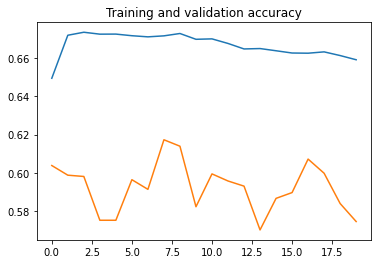

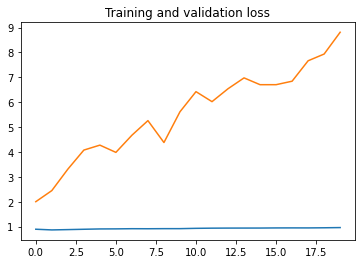

In [47]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = hist.history['acc']
val_acc = hist.history['val_acc']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [46]:
for key in hist.history:
    print(key)

loss
acc
val_loss
val_acc


In [19]:
model.save('model/vgg14_lastlayer/')

INFO:tensorflow:Assets written to: model/vgg14_lastlayer/assets


In [12]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights('cp/model1/')

In [14]:
model.predict(x)

array([[0.51473534, 0.03286876, 0.40865776, 0.00986098, 0.03387715]],
      dtype=float32)

# Fine tuning

In [15]:
# Unfreeze the base_model partially up to the last conv block
model.trainable = True
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten True
20 dense True
21 dropout True
22 dense_1 True


In [16]:
for layer in model.layers[:15]:
    layer.trainable = False

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable) 

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten True
20 dense True
21 dropout True
22 dense_1 True


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [18]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [19]:
checkpoint_filepath = 'cp/model2/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    save_freq='epoch',
    mode='max',
    save_best_only=True)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far

In [20]:
hist2 = model.fit(
    train_data,
    steps_per_epoch = train_data.samples // 32,
    validation_data = val_data, 
    validation_steps = val_data.samples // 32,
    epochs = 10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
7548/7548 [==============================] - 2679s 354ms/step - loss: 0.8822 - accuracy: 0.6468 - val_loss: 1.9977 - val_accuracy: 0.6398
Epoch 2/10
7548/7548 [==============================] - 918s 122ms/step - loss: 0.6818 - accuracy: 0.7352 - val_loss: 2.5972 - val_accuracy: 0.6855
Epoch 3/10
7548/7548 [==============================] - 915s 121ms/step - loss: 0.5985 - accuracy: 0.7693 - val_loss: 2.2638 - val_accuracy: 0.6949
Epoch 4/10
7548/7548 [==============================] - 910s 121ms/step - loss: 0.5446 - accuracy: 0.7908 - val_loss: 2.9602 - val_accuracy: 0.7231
Epoch 5/10
7548/7548 [==============================] - 910s 121ms/step - loss: 0.4977 - accuracy: 0.8099 - val_loss: 2.2920 - val_accuracy: 0.7288
Epoch 6/10
7548/7548 [==============================] - 914s 121ms/step - loss: 0.4656 - accuracy: 0.8221 - val_loss: 2.3533 - val_accuracy: 0.7198
Epoch 7/10
7548/7548 [==============================] - 917s 121ms/step - loss: 0.4284 - accuracy: 0.8351 - val

In [24]:
for key in hist2.history:
    print(key)

loss
accuracy
val_loss
val_accuracy


Text(0.5, 1.0, 'Training and validation loss')

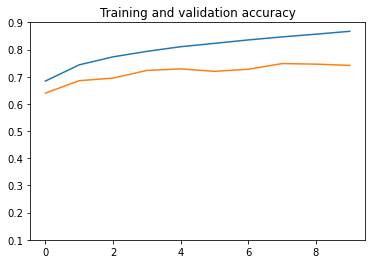

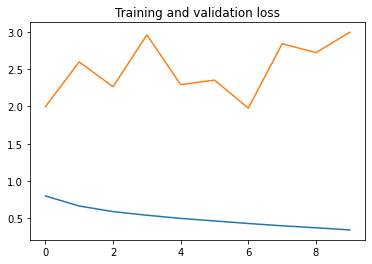

In [30]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = hist2.history['accuracy']
val_acc = hist2.history['val_accuracy']

loss = hist2.history['loss']
val_loss = hist2.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
axes = plt.gca()
axes.set_ylim([0.1,0.9])
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [21]:
model.save('model/vgg16_fine/')

INFO:tensorflow:Assets written to: model/vgg16_fine/assets


In [19]:
model = tf.keras.models.load_model('model/vgg16_fine/')

In [21]:
model.predict(x)

array([[5.8349353e-01, 1.0044876e-04, 4.0811870e-01, 3.7294731e-06,
        8.2835592e-03]], dtype=float32)

We see an improved score of 86%. We used just 10 epochs. Increasing their number should further improve the results.
Also, it is tempting to see further unfreezing the last and 2nd last conv block and training the model. We also try a more aggressive
data augmentation.

## Unfreezing last 2-layers


In [24]:
# Unfreeze the base_model partially up to the last conv block
model.trainable = True
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten True
20 dense True
21 dropout True
22 dense_1 True


In [25]:
for layer in model.layers[:11]:
    layer.trainable = False

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable) 

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten True
20 dense True
21 dropout True
22 dense_1 True


In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [27]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [28]:
checkpoint_filepath = 'cp/model3/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    save_freq='epoch',
    mode='max',
    save_best_only=True)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far

In [33]:
hist3 = model.fit(
    train_data,
    steps_per_epoch = train_data.samples // 32,
    validation_data = val_data, 
    validation_steps = val_data.samples // 32,
    epochs = 8,
    callbacks=[model_checkpoint_callback])

Epoch 1/8
7548/7548 [==============================] - 3521s 466ms/step - loss: 0.3781 - accuracy: 0.8573 - val_loss: 2.6526 - val_accuracy: 0.7618
Epoch 2/8
7548/7548 [==============================] - 1233s 163ms/step - loss: 0.3197 - accuracy: 0.8808 - val_loss: 2.2647 - val_accuracy: 0.7752
Epoch 3/8
7548/7548 [==============================] - 1232s 163ms/step - loss: 0.2775 - accuracy: 0.8966 - val_loss: 2.6003 - val_accuracy: 0.7806
Epoch 4/8
7548/7548 [==============================] - 1232s 163ms/step - loss: 0.2484 - accuracy: 0.9076 - val_loss: 1.9043 - val_accuracy: 0.7668
Epoch 5/8
7548/7548 [==============================] - 1232s 163ms/step - loss: 0.2176 - accuracy: 0.9188 - val_loss: 2.9780 - val_accuracy: 0.7843
Epoch 6/8
7548/7548 [==============================] - 1233s 163ms/step - loss: 0.1967 - accuracy: 0.9271 - val_loss: 3.1295 - val_accuracy: 0.7933
Epoch 7/8
7548/7548 [==============================] - 1233s 163ms/step - loss: 0.1729 - accuracy: 0.9358 - val_

In [34]:
model.save('model/vgg16_last2layers/')

INFO:tensorflow:Assets written to: model/vgg16_last2layers/assets


Text(0.5, 1.0, 'Training and validation loss')

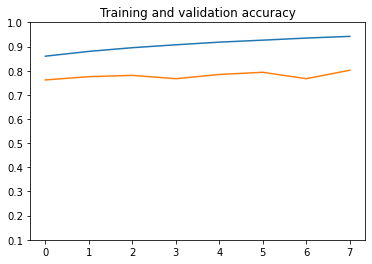

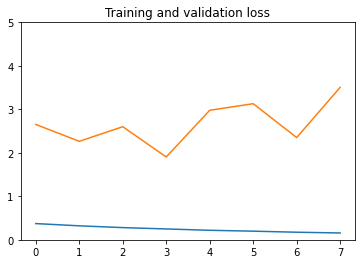

In [36]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = hist3.history['accuracy']
val_acc = hist3.history['val_accuracy']

loss = hist3.history['loss']
val_loss = hist3.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
axes = plt.gca()
axes.set_ylim([0.1,1])
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
axes = plt.gca()
axes.set_ylim([0,5])
plt.title('Training and validation loss')

## Unfreezing more layers

In [9]:
# Unfreeze the base_model partially up to the last conv block
model.trainable = True
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten True
20 dense True
21 dropout True
22 dense_1 True


In [10]:
for layer in model.layers[:7]:
    layer.trainable = False

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable) 

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten True
20 dense True
21 dropout True
22 dense_1 True


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [11]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [12]:
checkpoint_filepath = 'cp/model4/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    save_freq='epoch',
    mode='max',
    save_best_only=True)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far

In [ ]:
hist4 = model.fit(
    train_data,
    steps_per_epoch = train_data.samples // 32,
    validation_data = val_data, 
    validation_steps = val_data.samples // 32,
    epochs = 15,
    callbacks=[model_checkpoint_callback])

Epoch 1/15
7548/7548 [==============================] - 1642s 217ms/step - loss: 0.1764 - accuracy: 0.9364 - val_loss: 2.2946 - val_accuracy: 0.7826
Epoch 2/15
1757/7548 [=====>........................] - ETA: 20:44 - loss: 0.1426 - accuracy: 0.9484

In [34]:
model.save('model/vgg16_last3layers/')

INFO:tensorflow:Assets written to: model/vgg16_last2layers/assets


Text(0.5, 1.0, 'Training and validation loss')

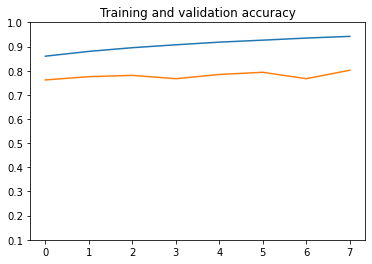

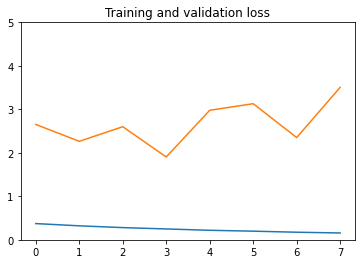

In [36]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = hist3.history['accuracy']
val_acc = hist3.history['val_accuracy']

loss = hist3.history['loss']
val_loss = hist3.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
axes = plt.gca()
axes.set_ylim([0.1,1])
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
axes = plt.gca()
axes.set_ylim([0,5])
plt.title('Training and validation loss')

## Load saved model

In [5]:
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
# load model
base_model = VGG16(include_top=False, input_shape=(128, 128, 3), weights=None)

local_weights_file = 'weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model.load_weights(local_weights_file)

# create new model on top
top_model = layers.Flatten()(base_model.layers[-1].output)
top_model =  layers.Dense(512, activation='relu')(top_model)

# Add a dropout rate of 0.5. Essential since these models would easily overfit out limited data
top_model = layers.Dropout(0.5)(top_model)
output = layers.Dense(5, activation='softmax')(top_model)

# define new model
model = Model(base_model.inputs, output)

model.load_weights('cp/model3/')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

## Performance on test set

In [5]:
labels_dir = 'TL/data/test/test_labels.csv'
labels = pd.read_csv(labels_dir)
labels.head()

,image_name,label
0,1447696357891.jpg,insect
1,1534166984180.jpg,butterfly
2,1475593574636.jpg,butterfly
3,image_04111.jpg,other
4,9585244628_e6a6d25a3d_w.jpg,bee


In [14]:
labels['label']=labels['label'].map({'bee': 0, 'butterfly': 1, 'insect': 2, 'other': 3, 'wasp': 4})
labels.head()

,image_name,label
0,1447696357891.jpg,2
1,1534166984180.jpg,1
2,1475593574636.jpg,1
3,image_04111.jpg,3
4,9585244628_e6a6d25a3d_w.jpg,0


In [ ]:
bee_img_files[1]

In [15]:
!rm -r TL/data/test/wasp/.ipynb_checkpoints
!rm -r TL/data/test/other/.ipynb_checkpoints
!rm -r TL/data/test/insect/.ipynb_checkpoints
!rm -r TL/data/test/butterfly/.ipynb_checkpoints
!rm -r TL/data/test/bee/.ipynb_checkpoints
!rm -r TL/data/test/.ipynb_checkpoints

rm: cannot remove 'TL/data/test/other/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'TL/data/test/insect/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'TL/data/test/butterfly/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'TL/data/test/bee/.ipynb_checkpoints': No such file or directory


In [16]:
all_img_path = []
test_dir = "TL/data/test/"
for sub_dir in os.listdir(test_dir):
    if sub_dir != 'test_labels.csv':
        class_dir = os.path.join("TL/data/test/", sub_dir)
        img_files = glob.glob(class_dir + "/*.jpg")
        img_files = img_files + glob.glob(class_dir + "/*.JPG")
    all_img_path.append(img_files)
all_img_path = [item for sublist in all_img_path for item in sublist]

In [17]:
len(all_img_path)

14983

In [18]:
acc = []
good_pred = []
bad_pred = []
skipped = 0
for i in range(len(all_img_path)): 
    img = load_img(all_img_path[i], target_size=(128, 128))  
    img = img_to_array(img)  
    img = img.reshape((1,) + img.shape) 
    img /= 255
    try:
        pred = np.argmax(model.predict(img),axis=1)
        path, file = os.path.split(all_img_path[i])
        tmp = labels.loc[labels.image_name == file].label == pred
        if tmp:
            good_pred.append(all_img_path[i])
        else:
            bad_pred.append(all_img_path[i])     
    except:
        skipped = skipped + 1
        pass
    acc.append(tmp.values[0])

In [24]:
print("Test accuracy: ",np.sum(acc)/len(acc))

Test accuracy:  0.7345658412867917


## Final Explainability code

In [5]:
zf = zipfile.ZipFile('XAI.zip', 'r')

In [6]:
with zf as zip_ref:
     zip_ref.extractall(r"XAI/")

In [6]:
labels_dir_xai = 'XAI/XAI/explain.csv'
labels_xai = pd.read_csv(labels_dir_xai)
labels_xai.head()

,label,xmin,ymin,xmax,ymax,xmid,ymid,img,im_width,im_height
0,butterfly,0,28,75,102,37,65,0a83c6e7-76dd-4063-8350-9400cc75d232.jpg,128,128
1,wasp,10,39,86,75,48,57,0b2187c4-e092-4d95-9e56-bb5a7e494223.JPG,128,128
2,butterfly,13,33,38,57,25,45,2c268355-c180-413e-a8f1-2d32f30eeafa.jpg,128,128
3,insect,47,34,110,84,78,59,4c54699f-be25-40c7-a42e-51e511c12753.jpg,128,128
4,wasp,41,31,82,79,61,55,4d7a9b4c-3b17-4af4-9e3a-5fa940bc4081.jpg,128,128


In [7]:
labels_xai['label']=labels_xai['label'].map({'bee': 0, 'butterfly': 1, 'insect': 2, 'other': 3, 'wasp': 4})
labels_xai.head()

,label,xmin,ymin,xmax,ymax,xmid,ymid,img,im_width,im_height
0,1,0,28,75,102,37,65,0a83c6e7-76dd-4063-8350-9400cc75d232.jpg,128,128
1,4,10,39,86,75,48,57,0b2187c4-e092-4d95-9e56-bb5a7e494223.JPG,128,128
2,1,13,33,38,57,25,45,2c268355-c180-413e-a8f1-2d32f30eeafa.jpg,128,128
3,2,47,34,110,84,78,59,4c54699f-be25-40c7-a42e-51e511c12753.jpg,128,128
4,4,41,31,82,79,61,55,4d7a9b4c-3b17-4af4-9e3a-5fa940bc4081.jpg,128,128


In [8]:
labels_xai.columns = ['label', 'xmin', 'ymin', 'xmax', 'ymax', 'xmid', 'ymid', 'image_name', 'im_width', 'im_height']
labels_xai.head()

,label,xmin,ymin,xmax,ymax,xmid,ymid,image_name,im_width,im_height
0,1,0,28,75,102,37,65,0a83c6e7-76dd-4063-8350-9400cc75d232.jpg,128,128
1,4,10,39,86,75,48,57,0b2187c4-e092-4d95-9e56-bb5a7e494223.JPG,128,128
2,1,13,33,38,57,25,45,2c268355-c180-413e-a8f1-2d32f30eeafa.jpg,128,128
3,2,47,34,110,84,78,59,4c54699f-be25-40c7-a42e-51e511c12753.jpg,128,128
4,4,41,31,82,79,61,55,4d7a9b4c-3b17-4af4-9e3a-5fa940bc4081.jpg,128,128


In [101]:
make_plots = False
score = []
for i in range(labels_xai.shape[0]):
    img_path = "XAI/XAI/data/" + labels_xai.iloc[i]['image_name']
    heatmap, pred, ground_truth = explain(img_path, img_size, model, last_conv_layer_name, classifier_layer_names, labels_xai, make_plots)
    top_label_idx = np.argmax(pred[0])
    pred =  list(data_class.keys())[list(data_class.values()).index(top_label_idx)]
    if np.all((heatmap == 0)) == True:
        print('No feature attribution')
        score.append(0.5)
    elif pred != ground_truth:
        print('Wrong prediction')
        print(pred, ground_truth)
        score.append(1)
    else:
        x_ind = np.unravel_index(np.argmax(heatmap, axis=None), heatmap.shape)[0]*16
        y_ind = np.unravel_index(np.argmax(heatmap, axis=None), heatmap.shape)[1]*16
        x_ind_true = labels_xai.iloc[i]['xmid']
        y_ind_true = labels_xai.iloc[i]['ymid']
        dist = np.sqrt(((x_ind/128-x_ind_true/128)**2 + (y_ind/128-y_ind_true/128)**2))
        is_in = x_ind>=labels_xai.iloc[i]['xmin'] and x_ind <= labels_xai.iloc[i]['xmax'] and y_ind>=labels_xai.iloc[i]['ymin'] and y_ind <= labels_xai.iloc[i]['ymax']
        if is_in==True:
            score.append(dist)
        else:
            score.append(dist + dist**2)
        """print('The predicted center is: ', x_ind,y_ind)
        print('The actual center is: ', x_ind_true, y_ind_true)
        print('The distance is: ', dist)
        print('The predicted center is in the annotated bounding-box: ', is_in)
        print('The score is: ', score)
        print(heatmap)"""
        if make_plots == True:
            imgx = load_img(img_path, target_size=(128, 128))  # this is a PIL image
            x = img_to_array(imgx)  # Numpy array with shape (150, 150, 3)
            x = keras.preprocessing.image.array_to_img(x)
            plt.figure(2)
            plt.imshow(x)
            plt.plot(y_ind,x_ind, marker='o',markeredgecolor='red',markerfacecolor='blue', markersize=20, markeredgewidth=5)
            plt.plot(x_ind_true,y_ind_true, marker='o',markeredgecolor='green',markerfacecolor='yellow', markersize=20, markeredgewidth=5)

No feature attribution
No feature attribution
Wrong prediction
insect wasp


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


No feature attribution
No feature attribution
No feature attribution
Wrong prediction
bee wasp
Wrong prediction
bee wasp
Wrong prediction
insect wasp
Wrong prediction
insect wasp
Wrong prediction
other wasp
Wrong prediction
insect wasp
Wrong prediction
insect wasp
Wrong prediction
butterfly insect
No feature attribution
Wrong prediction
bee insect
No feature attribution


In [102]:
score

[0.33310946258324753,
 0.9211036452362917,
 0.5,
 0.5,
 1,
 0.7584052632894548,
 0.5,
 0.5,
 0.5,
 0.8576029540519903,
 0.321168824860851,
 0.25194555463432966,
 1.2214606146315394,
 1.1136974030111908,
 0.8983164952762608,
 0.2166472597478445,
 1,
 1,
 0.7116614543835007,
 0.48983816239425343,
 0.6415413156509219,
 1,
 1,
 1,
 0.37925360358005406,
 0.20846350100197397,
 1,
 0.22990529639940877,
 0.1570293065800139,
 0.16029909788033744,
 1.0166136151445448,
 1,
 0.04555431167847891,
 0.09375,
 0.9239385499949325,
 0.35848405592085814,
 1,
 0.5,
 0.9165616533077053,
 1,
 0.04555431167847891,
 0.23228232417685166,
 0.10881553341550093,
 0.5,
 0.16105881350068987,
 0.48589496064371207,
 0.5477967236613006,
 1.0926089726009793,
 1.0784082091487994,
 0.9342330034087833]

In [103]:
sum(score)

31.41300425347508

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The predicted center is:  48 0
The actual center is:  45 80
The distance is:  0.6254392987382948
The predicted center is in the annotated bounding-box:  False
The penalty is:  [1.0166136151445448]


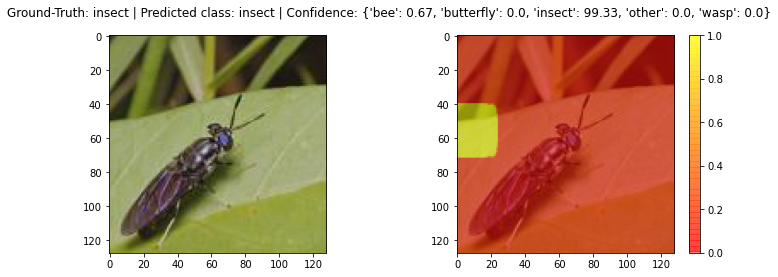

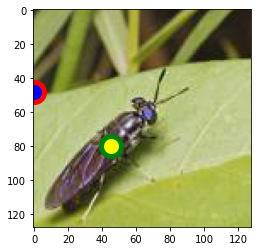

In [119]:
make_plots = True
score = []
i = 30
img_path = "XAI/XAI/data/" + labels_xai.iloc[i]['image_name']
heatmap, pred, ground_truth = explain(img_path, img_size, model, last_conv_layer_name, classifier_layer_names, labels_xai, make_plots)
top_label_idx = np.argmax(pred[0])
pred =  list(data_class.keys())[list(data_class.values()).index(top_label_idx)]
if np.all((heatmap == 0)) == True:
    print('No feature attribution')
    score.append(1)
elif pred != ground_truth:
    print('Wrong prediction')
    print(pred, ground_truth)
    score.append(1)
else:
    x_ind = np.unravel_index(np.argmax(heatmap, axis=None), heatmap.shape)[0]*16
    y_ind = np.unravel_index(np.argmax(heatmap, axis=None), heatmap.shape)[1]*16
    x_ind_true = labels_xai.iloc[i]['xmid']
    y_ind_true = labels_xai.iloc[i]['ymid']
    dist = np.sqrt(((x_ind/128-x_ind_true/128)**2 + (y_ind/128-y_ind_true/128)**2))
    is_in = x_ind>=labels_xai.iloc[i]['xmin'] and x_ind <= labels_xai.iloc[i]['xmax'] and y_ind>=labels_xai.iloc[i]['ymin'] and y_ind <= labels_xai.iloc[i]['ymax']
    if is_in==True:
        score.append(dist)
    else:
        score.append(dist + dist**2)
    print('The predicted center is: ', x_ind,y_ind)
    print('The actual center is: ', x_ind_true, y_ind_true)
    print('The distance is: ', dist)
    print('The predicted center is in the annotated bounding-box: ', is_in)
    print('The penalty is: ', score)
    #print(heatmap)
    if make_plots == True:
        imgx = load_img(img_path, target_size=(128, 128))  # this is a PIL image
        x = img_to_array(imgx)  # Numpy array with shape (150, 150, 3)
        x = keras.preprocessing.image.array_to_img(x)
        plt.figure(2)
        plt.imshow(x)
        plt.plot(y_ind,x_ind, marker='o',markeredgecolor='red',markerfacecolor='blue', markersize=20, markeredgewidth=5)
        plt.plot(x_ind_true,y_ind_true, marker='o',markeredgecolor='green',markerfacecolor='yellow', markersize=20, markeredgewidth=5)

In [73]:
print(heatmap)

[[  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [255   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]


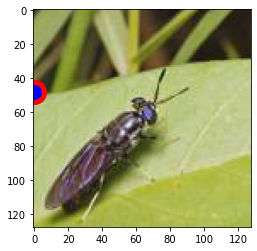

In [75]:
imgx = load_img(img_path, target_size=(128, 128))  # this is a PIL image
x = img_to_array(imgx)  # Numpy array with shape (150, 150, 3)
x = keras.preprocessing.image.array_to_img(x)
plt.imshow(x)
plt.plot(y_ind,x_ind, marker='o',markeredgecolor='red',markerfacecolor='blue', markersize=20, markeredgewidth=5)

In [12]:
all_img_path_xai = []
test_dir = "XAI/XAI/data/"
for sub_dir in os.listdir(test_dir):
    if sub_dir != 'valid_labels.csv':
        class_dir = test_dir#os.path.join("TL/data/val/", sub_dir)
        img_files = glob.glob(class_dir + "/*.jpg")
        img_files = img_files + glob.glob(class_dir + "/*.JPG")
    all_img_path_xai.append(img_files)
all_img_path_xai = [item for sublist in all_img_path_xai for item in sublist]

In [9]:
all_img_path_xai[0]

'XAI/XAI/data/556817.jpg'

In [13]:
!zip -r vggModels.zip model

  adding: model/ (stored 0%)
  adding: model/final/ (stored 0%)
  adding: model/vgg14_lastlayer/ (stored 0%)
  adding: model/vgg14_lastlayer/variables/ (stored 0%)
  adding: model/vgg14_lastlayer/variables/variables.data-00000-of-00001 (deflated 20%)
  adding: model/vgg14_lastlayer/variables/variables.index (deflated 67%)
  adding: model/vgg14_lastlayer/assets/ (stored 0%)
  adding: model/vgg14_lastlayer/saved_model.pb (deflated 91%)
  adding: model/.ipynb_checkpoints/ (stored 0%)
  adding: model/vgg16_full_train/ (stored 0%)
  adding: model/vgg16_full_train/variables/ (stored 0%)
  adding: model/vgg16_full_train/variables/variables.data-00000-of-00001 (deflated 21%)
  adding: model/vgg16_full_train/variables/variables.index (deflated 67%)
  adding: model/vgg16_full_train/assets/ (stored 0%)
  adding: model/vgg16_full_train/saved_model.pb (deflated 90%)
  adding: model/vgg16_last3layers/ (stored 0%)
  adding: model/vgg16_last3layers/variables/ (stored 0%)
  adding: model/vgg16_last3lay

In [9]:
img_size = (128, 128)

data_class = {'bee': 0, 'butterfly': 1, 'insect': 2, 'other': 3, 'wasp': 4}

last_conv_layer_name = "block5_conv3"
classifier_layer_names = [
    "block5_pool",
    "flatten",
    "dense",
    "dropout",
    "dense_1",
]

In [10]:
#adapted from fchollet
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])

    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
                
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        
        top_pred_index = tf.argmax(preds[0])
        
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    #print(grads)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]

    pooled_grads = pooled_grads.numpy()
    #print(pooled_grads)
    #print(np.size(pooled_grads))
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    #print(last_conv_layer_output)
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    #print(heatmap)
    return heatmap

In [11]:
def plot_map(grads,img,preds,ground_truth):
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    axes[0].imshow(img)
    axes[1].imshow(img)
    idx = np.argmax(preds[0])
    actual =  list(data_class.keys())[list(data_class.values()).index(idx)]
    if actual!=ground_truth:
        params = {"text.color" : "crimson",
          "xtick.color" : "black",
          "ytick.color" : "black"}
        plt.rcParams.update(params)
        i = axes[1].imshow(grads,cmap="autumn",alpha=0.5)
        conf = {'bee': np.around(preds[0]*100,2)[0], 'butterfly': np.around(preds[0]*100,2)[1],
                'insect': np.around(preds[0]*100,2)[2], 'other': np.around(preds[0]*100,2)[3], 'wasp': np.around(preds[0]*100,2)[4]}
        fig.colorbar(i)
        plt.suptitle("Ground-Truth: {} | Predicted class: {} | Confidence: {}".format(ground_truth, actual, conf))
        #plt.savefig('xai_{}.png'.format(random.randint(1,1000)))
    else:
        params = {"text.color" : "black",
          "xtick.color" : "black",
          "ytick.color" : "black"}
        plt.rcParams.update(params)
        i = axes[1].imshow(grads,cmap="autumn",alpha=0.5)
        conf = {'bee': np.around(preds[0]*100,2)[0], 'butterfly': np.around(preds[0]*100,2)[1],
                'insect': np.around(preds[0]*100,2)[2], 'other': np.around(preds[0]*100,2)[3], 'wasp': np.around(preds[0]*100,2)[4]}
        fig.colorbar(i)
        plt.suptitle("Ground-Truth: {} | Predicted class: {} | Confidence: {}".format(ground_truth, actual, conf))
        #plt.savefig('xai_{}.png'.format(random.randint(1,1000)))

In [51]:
def explain(img_path, img_size, model, last_conv_layer_name, classifier_layer_names, labels, make_plots):
    img_org = load_img(img_path, target_size=img_size) 
    x = img_to_array(img_org)  
    x = x.reshape((1,) + x.shape)  
    x /= 255
    preds = model.predict(x)
    
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(
        x, model, last_conv_layer_name, classifier_layer_names
    )
    
    # We load the original image
    img = keras.preprocessing.image.img_to_array(img_org)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    #print(heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("autumn")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    #print(jet_heatmap)
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    path, file = os.path.split(img_path)
    ground_truth = labels.loc[labels.image_name == file]['label'].values[0] #.label

    ground_truth = list(data_class.keys())[list(data_class.values()).index(ground_truth)]
    #plot_map(superimposed_img, img_org, preds, ground_truth)
    if make_plots == True:
        plot_map(jet_heatmap*0.4, img_org, preds, ground_truth)
    return heatmap, preds, ground_truth

230.0


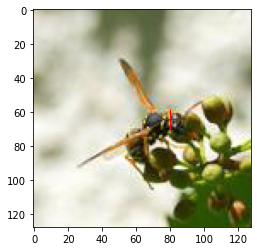

In [78]:
imgx = load_img(img_path, target_size=(128, 128))  # this is a PIL image
x = img_to_array(imgx)  # Numpy array with shape (150, 150, 3)
tmp = x[:,:,-1].reshape(128,128)
x = keras.preprocessing.image.array_to_img(x)#x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
# Rescale by 1/255
#locx=tmp[127]
#locy=tmp[1,1]
print(tmp[0,127])
#x /= 255
plt.imshow(x)
plt.plot(5*16,4*16, 'r+',markersize=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0 238 255   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]


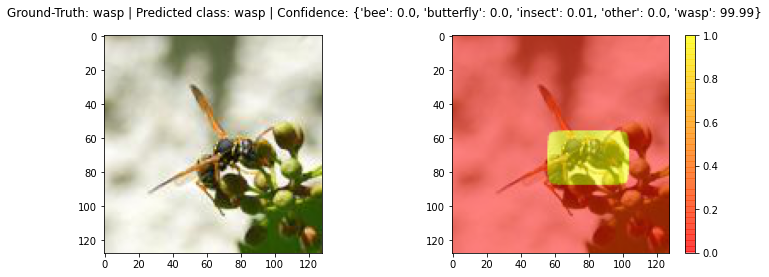

In [69]:
explain(img_path, img_size, model, last_conv_layer_name, classifier_layer_names, labels_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[[ 0.0000000e+00  9.8742021e-04  6.4223295e-04 ...  3.8235544e-03
    -3.5863754e-03 -5.9616756e-05]
   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]
   [ 0.0000000e+00  4.2255847e-03  0.0000000e+00 ...  6.9623096e-03
    -2.5596230e-03  2.6148472e-03]
   ...
   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]
   [ 1.6344801e-03  1.0476531e-04  9.8124449e-04 ...  4.5028408e-03
    -4.1050659e-03  2.8437949e-04]
   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]]

  [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]
   [ 9.4995019e-04  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]
   [ 1.0348781e-03  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]
   ...
   [ 0.0000000e+00  0.0000000e+00  0.0000000e+

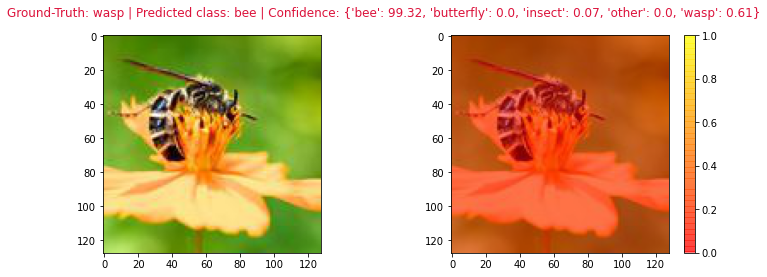

In [28]:
for i in range(1):
    img_path = random.choice(all_img_path_val)
    explain(img_path, img_size, model, last_conv_layer_name, classifier_layer_names, labels_val)